**Introduction**

This project focuses on detecting phishing URLs using machine learning techniques. The main goal is to develop a system that can automatically classify URLs as phishing or legitimate based solely on their structure and content patterns. By extracting meaningful features from URLs and applying multiple ML algorithms, including XGBoost, AdaBoost, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM), we aim to create an accurate, interpretable, and efficient phishing detection framework. The project avoids web scraping or HTML content analysis, making it lightweight and fast.

1. In this section, the dataset containing website URLs was first loaded. For each URL, the protocol and domain were removed to keep only the path after the domain. These paths were then split by the / delimiter into individual keywords, filtering out empty strings and query parameters. By collecting all keywords from the entire dataset and counting their frequencies, a table of the most common keywords was created. Finally, a bar chart of the top 100 keywords was plotted to visualize frequent patterns in phishing URLs. This step helps identify recurring words and patterns in suspicious links and provides a foundation for feature engineering in phishing detection models.


/tmp/ipython-input-3558712958.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=top_keywords, palette='viridis')


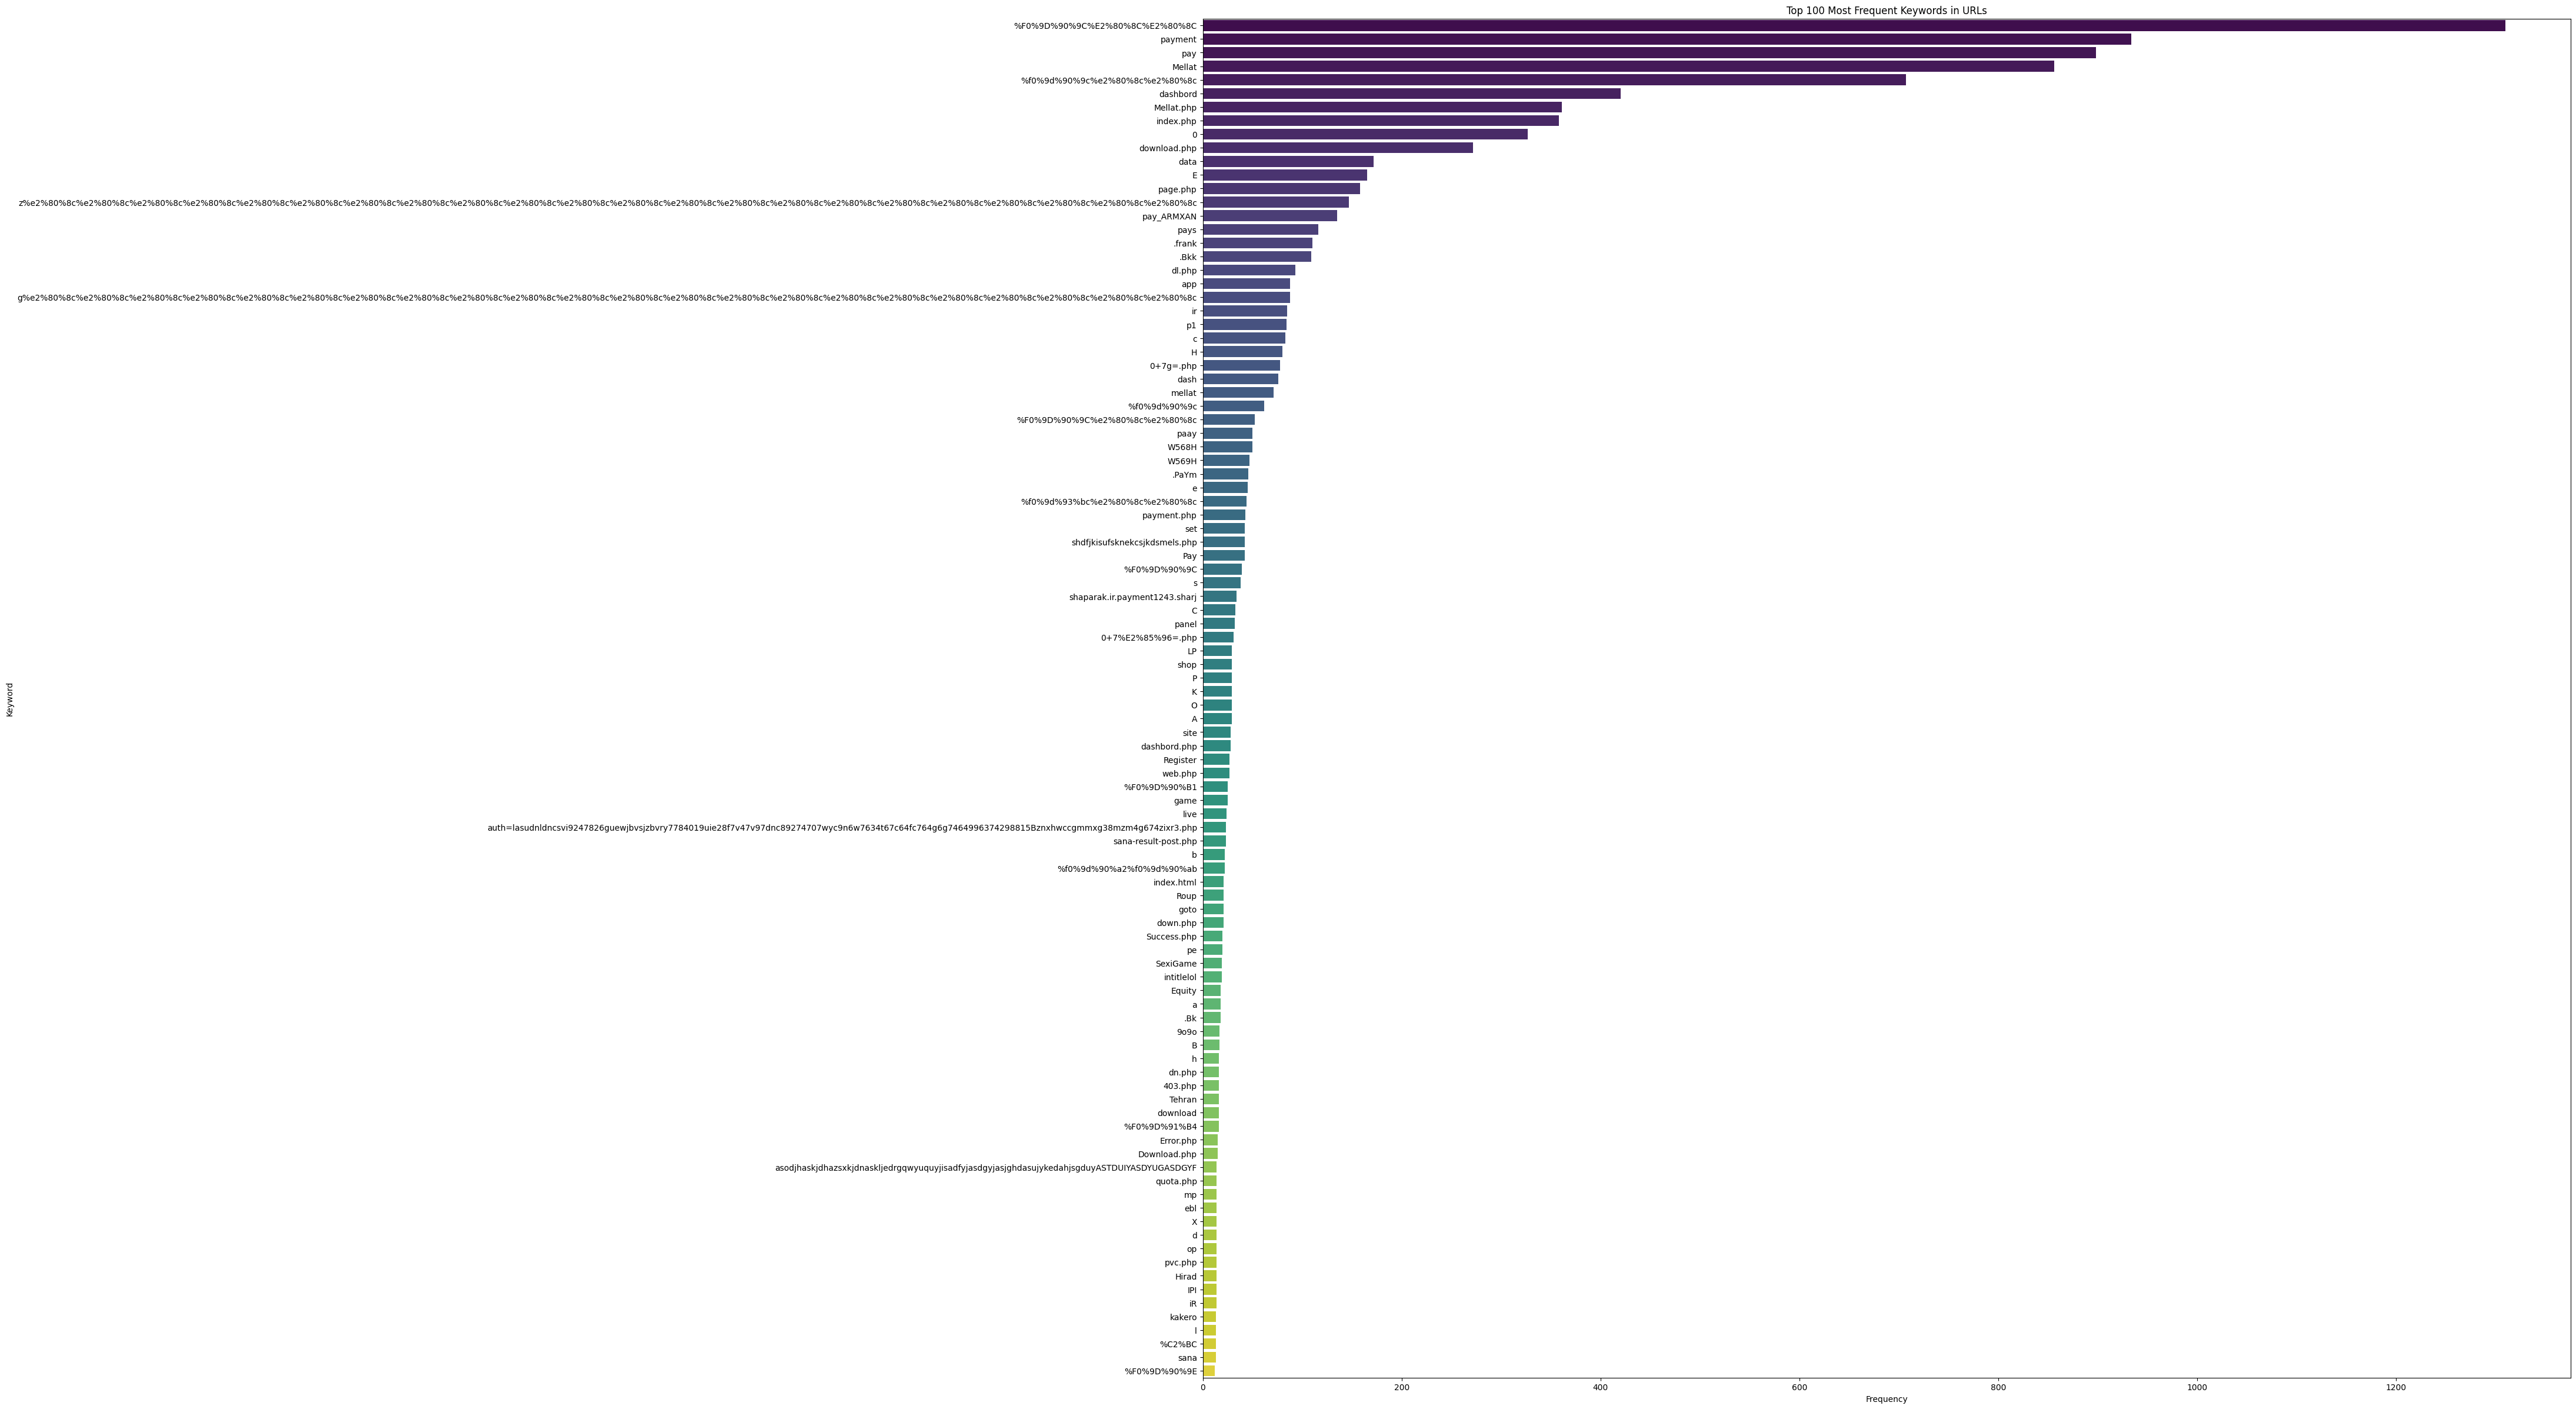

In [ ]:
import pandas as pd
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the Excel file
file_path = 'Fishing.xlsx'  # replace with your Excel file path
df = pd.read_excel(file_path)

# Step 2: Extract the 'URL' column
urls = df['url'].astype(str)  # Assuming the column containing URLs is named 'url'

# Step 3: Function to clean and extract keywords after the domain
def extract_keywords_from_url(url):
    # Remove the protocol (http/https) and domain
    url = re.sub(r'https?://[^/]+', '', url)

    # Split the URL based on the `/` delimiter (only keep the part after the domain)
    keywords = url.split('/')

    # Filter out empty strings and ignore query parameters
    keywords = [kw for kw in keywords if kw and '?' not in kw]

    return keywords

# Step 4: Collect all keywords from all URLs
all_keywords = []
for url in urls:
    all_keywords.extend(extract_keywords_from_url(url))

# Step 5: Count the frequency of each keyword
keyword_counts = Counter(all_keywords)

# Step 6: Convert keyword counts to a DataFrame for visualization
keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Frequency'])

# Step 7: Sort the DataFrame by frequency for better visualization
keyword_df = keyword_df.sort_values(by='Frequency', ascending=False)


# Step 9: Create a bar chart for the top N most frequent keywords
top_n = 100  # You can adjust this to show more or fewer top keywords
top_keywords = keyword_df.head(top_n)

plt.figure(figsize=(30, 30))
sns.barplot(x='Frequency', y='Keyword', data=top_keywords, palette='viridis')
plt.title(f'Top {top_n} Most Frequent Keywords in URLs')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

2. In this section, the URLs from the dataset were analyzed to extract structural features, including subdomains, site names, and domain extensions. Each URL was parsed using urlparse, and the domain was split into its components to identify the subdomain (if present), the main site name, and the extension (TLD). The occurrences of each component were counted across the dataset to identify the most frequent subdomains, site names, and extensions used in phishing links. Finally, bar charts were generated to visualize these distributions. This analysis provides insights into common patterns in phishing URLs and can be used to engineer features that improve the performance of phishing detection models.

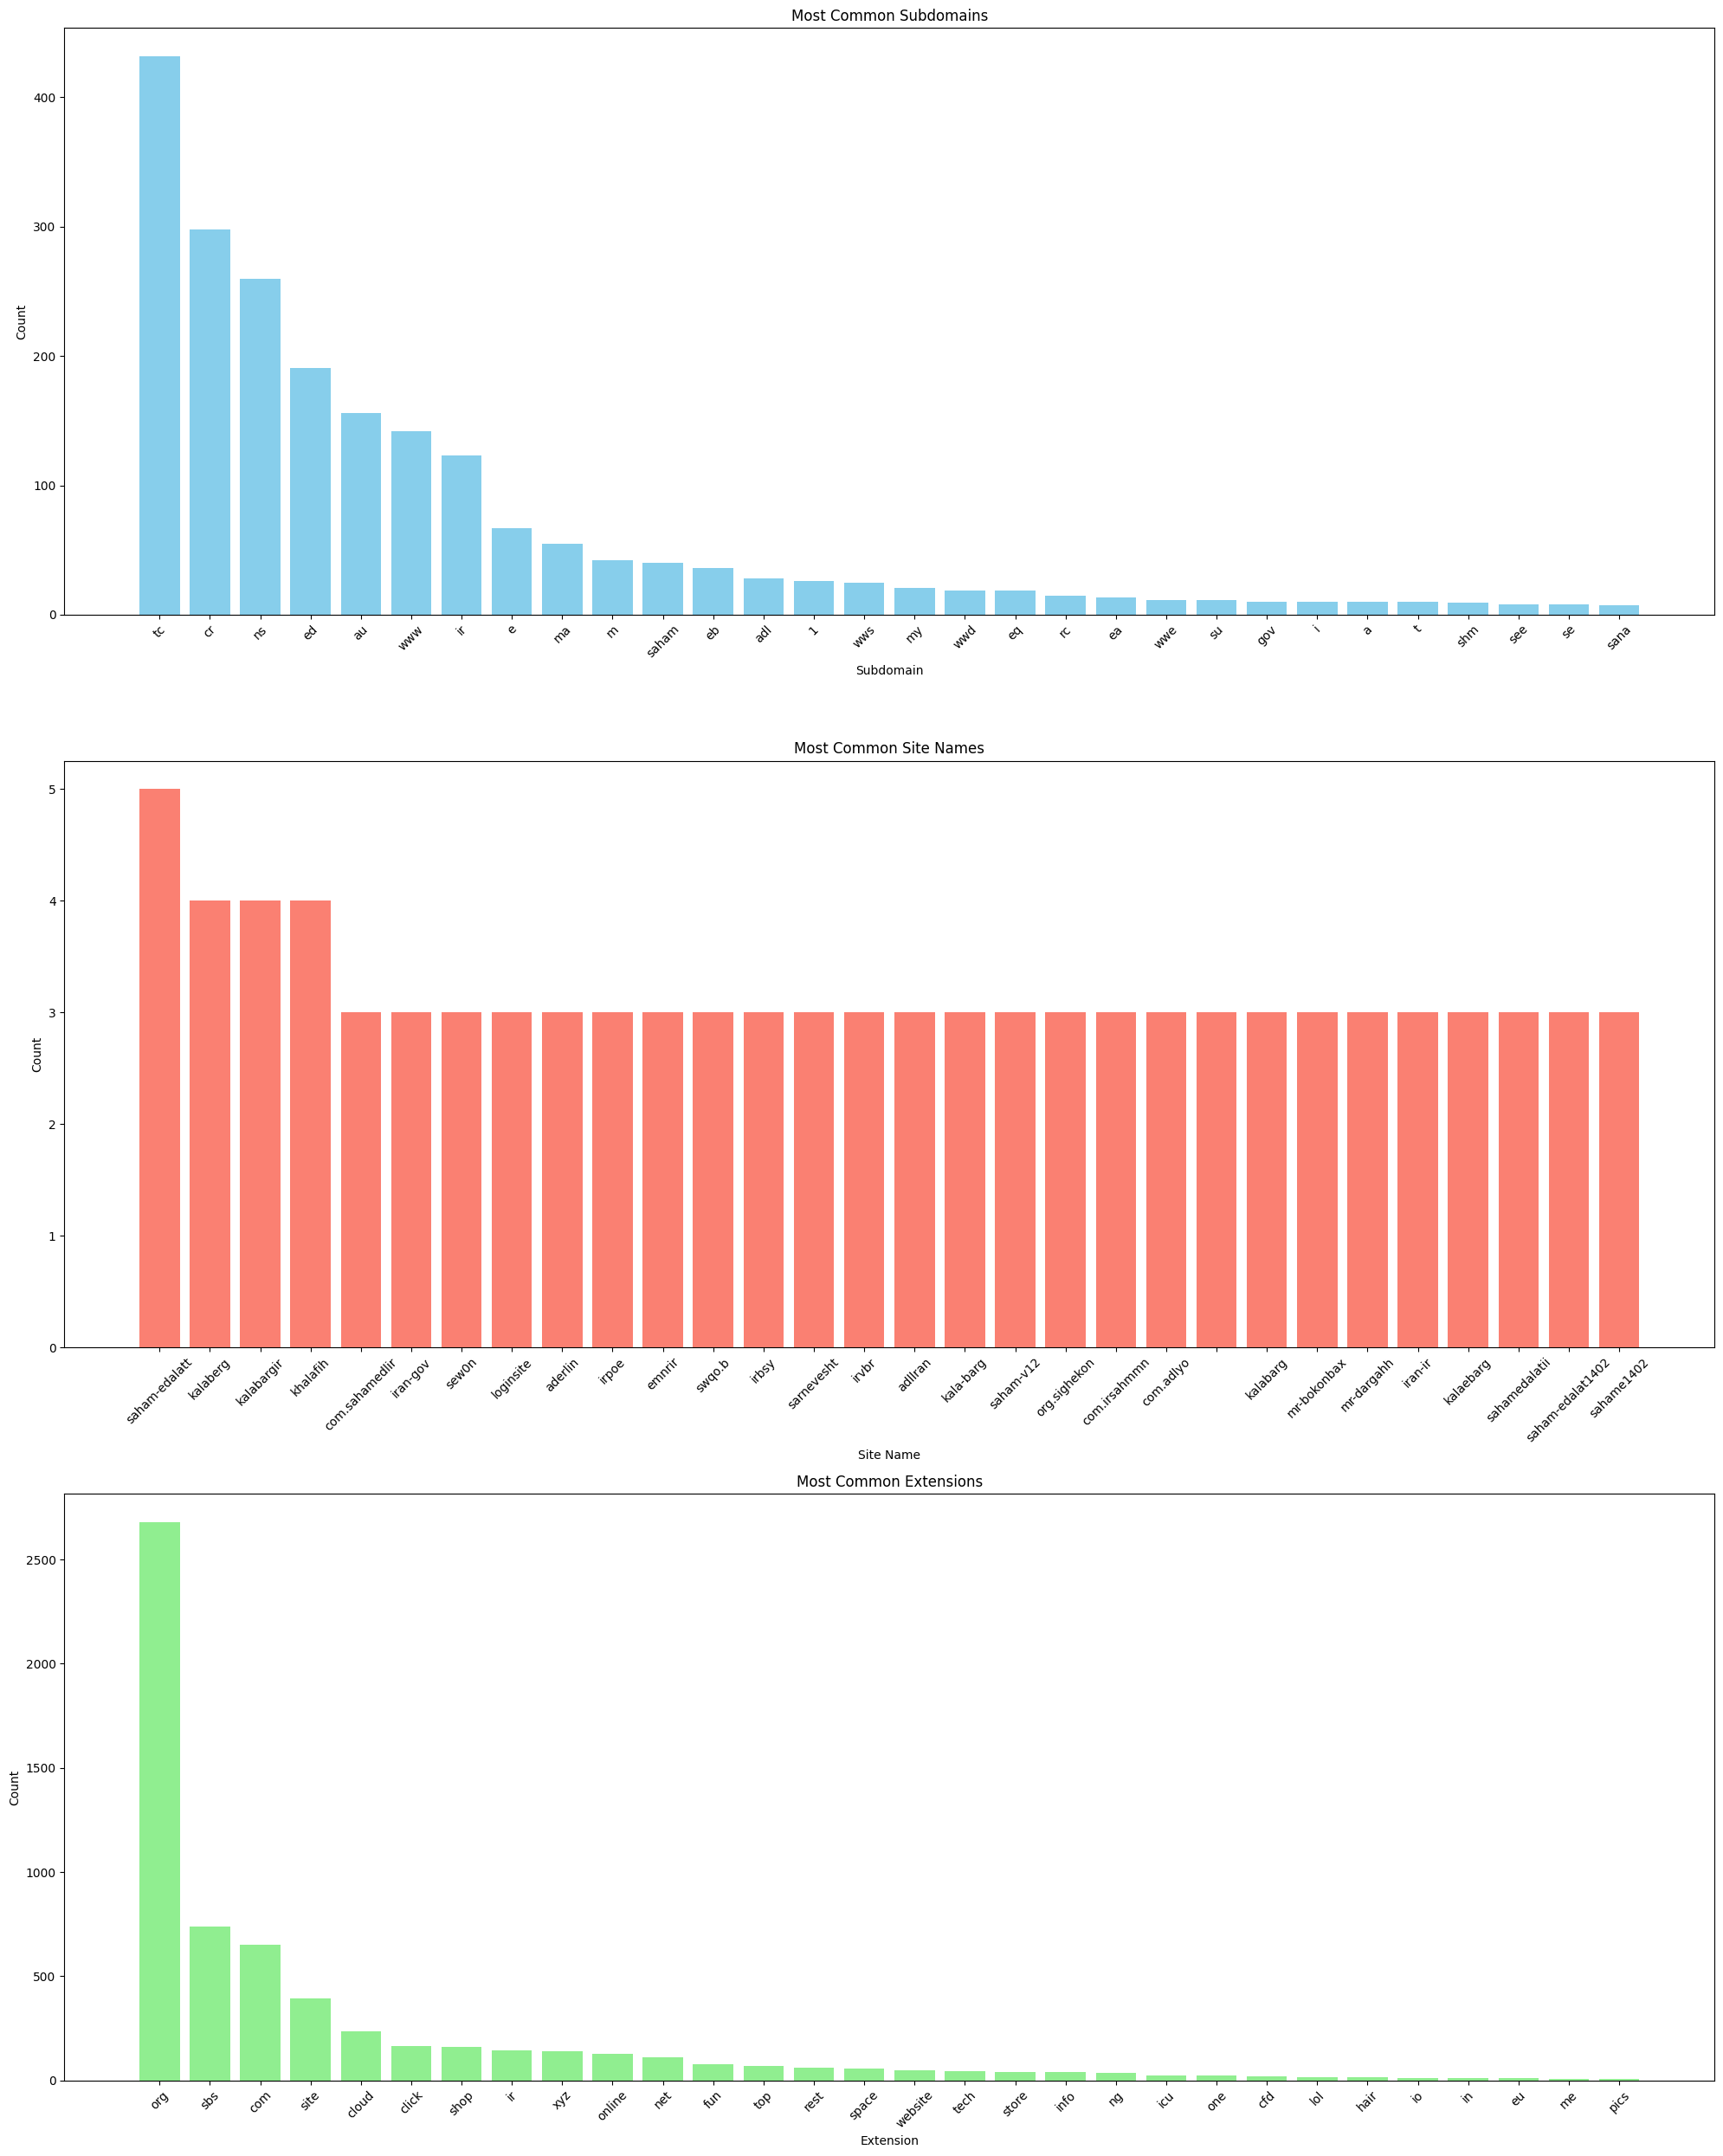

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from urllib.parse import urlparse

# Read the Excel file
file_path = 'Fishing.xlsx'  # Replace with your Excel file path
df = pd.read_excel(file_path)

# Assuming the URL column is named 'url'
urls = df['url'].dropna().tolist()

# Function to extract subdomains, site names, and extensions
def extract_url_components(url):
    parsed_url = urlparse(url)
    domain_parts = parsed_url.netloc.split('.')

    # Extract subdomains, site names, and extensions
    if len(domain_parts) > 2:
        subdomain = '.'.join(domain_parts[:-2])
        site_name = domain_parts[-2] + '.' + domain_parts[-3]
    else:
        subdomain = ''
        site_name = domain_parts[0]

    extension = domain_parts[-1]

    return subdomain, site_name, extension

# Lists to store extracted components
subdomains = []
site_names = []
extensions = []

# Extract components from each URL
for url in urls:
    subdomain, site_name, extension = extract_url_components(url)
    if subdomain:  # Only append subdomain if it exists
        subdomains.append(subdomain)
    site_names.append(site_name)
    extensions.append(extension)

# Count occurrences
subdomain_counts = Counter(subdomains)
site_name_counts = Counter(site_names)
extension_counts = Counter(extensions)

# Plotting the results
fig, axs = plt.subplots(3, 1, figsize=(20, 25))

# Most common subdomains
axs[0].bar(*zip(*subdomain_counts.most_common(30)), color='skyblue')
axs[0].set_title('Most Common Subdomains')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Subdomain')
axs[0].tick_params(axis='x', rotation=45)

# Most common site names
axs[1].bar(*zip(*site_name_counts.most_common(30)), color='salmon')
axs[1].set_title('Most Common Site Names')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Site Name')
axs[1].tick_params(axis='x', rotation=45)

# Most common extensions
axs[2].bar(*zip(*extension_counts.most_common(30)), color='lightgreen')
axs[2].set_title('Most Common Extensions')
axs[2].set_ylabel('Count')
axs[2].set_xlabel('Extension')
axs[2].tick_params(axis='x', rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

3. In this section, a machine learning-based phishing detection system is implemented using multiple algorithms: XGBoost, AdaBoost, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM). Features are extracted directly from URLs, including URL length, domain length, number of slashes and percent symbols, and the presence of phishing-related keywords. The dataset is split into training and testing sets, and each model is trained and evaluated separately using accuracy and classification metrics. Additionally, a helper function predict_url(url) is provided to test any new URL against all trained models simultaneously, displaying whether each algorithm classifies it as phishing or legitimate. This approach allows fast and scalable phishing detection without relying on web scraping or HTML content analysis.

In [ ]:
"""
Phishing URL Detection using Machine Learning

This script implements a phishing URL detection system using multiple ML algorithms:
XGBoost, AdaBoost, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM) with TF-IDF features.

Features are extracted directly from URLs without web scraping or HTML content fetching.
"""

import pandas as pd
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

# ----------------------------
# 1. Load dataset
# ----------------------------
df = pd.read_excel('website-train.xlsx')  # Columns: 'url' and 'is_phishing'

# ----------------------------
# 2. Feature extraction function
# ----------------------------
def extract_features(url):
    """
    Extract simple structural and keyword features from a URL.
    """
    features = {}
    parsed_url = urlparse(url)

    # Basic URL structure features
    features['url_length'] = len(url)
    features['domain_length'] = len(parsed_url.netloc)
    features['num_slash'] = url.count('/')
    features['num_percent'] = url.count('%')

    # Phishing-related keywords (simplified for demonstration)
    keywords = ['@', '%', "paymentpayment", "pay", "Mellat", "dashbord", "Mellat.php", "index.php", "download.php",
                "page.php", "pay_ARMXAN", "pays", ".frank", ".Bkk", "dl.php", "app", "ir", "dash", "mellat",
                "payment.php", "set", "Pay", "panel", "shop", "site", "dashbord.php", "Register", "web.php", "game",
                "live", "sana-result-post.php", "down.php", "index.html", "goto", "Success.php", "SexiGame",
                "intitlelol", "Equity", ".Bk", "dn.php", "download", "403.php", "Tehran", "Error.php", "Download.php",
                "IPI", "X", "sana", "kakero", "Tanha", "start.php", "Payment", "adliran", "Manst", "saham",
                "client.html", "into.php", "Sana.php", "itsOK", "404.html", "dambalikosi.php", "index2.php",
                "result.php", "index2.html", "Vpn", "3.php", "Ir", "eblagh.html", "install.php", "portal",
                "kalabarg.ir", "maeshati", "LoginPages.php", "tar.php", "Khalafi", "fa.html", "successed.php",
                "payment.mellat", "dargah", "Edalattt", "Basa", "404.php", "Edlatt", "IP.php", "wp", "mellat3", "mini",
                "SGame", "pk.php", "adl", "AutoPay-", "Index", "ind_ok.php", "pay.php", "iamARMXAN", "cgi-bin", "itsOK", "dlApp.php"]
    for kw in keywords:
        features[f'has_{kw.lower()}'] = kw.lower() in url.lower()

    return features

# ----------------------------
# 3. Apply feature extraction
# ----------------------------
features_df = df['url'].apply(extract_features).apply(pd.Series)
X = features_df
y = df['is_phishing']

# ----------------------------
# 4. Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# 5. XGBoost Classifier
# ----------------------------
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
print("----- XGBoost -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# ----------------------------
# 6. AdaBoost Classifier
# ----------------------------
model_ada = AdaBoostClassifier(n_estimators=50, random_state=42)
model_ada.fit(X_train, y_train)
y_pred = model_ada.predict(X_test)
print("----- AdaBoost -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# ----------------------------
# 7. KNN Classifier
# ----------------------------
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("----- KNN -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# ----------------------------
# 8. TF-IDF + SVM
# ----------------------------
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,5))
X_tfidf = vectorizer.fit_transform(df['url'])
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

model_svm = SVC(kernel='linear', C=1, random_state=42)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
print("----- SVM -----")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# ----------------------------
# 9. Function to predict a single URL
# ----------------------------
def predict_url(url):
    """
    Predict whether a single URL is phishing or legitimate using all trained models.
    """
    features = pd.DataFrame([extract_features(url)])

    pred_xgb = model_xgb.predict(features)[0]
    pred_ada = model_ada.predict(features)[0]
    features_scaled = scaler.transform(features)
    pred_knn = knn.predict(features_scaled)[0]
    pred_svm = model_svm.predict(vectorizer.transform([url]))[0]

    print(f"\nPredictions for URL: {url}")
    print(f"XGBoost: {'Phishing' if pred_xgb==1 else 'Legitimate'}")
    print(f"AdaBoost: {'Phishing' if pred_ada==1 else 'Legitimate'}")
    print(f"KNN: {'Phishing' if pred_knn==1 else 'Legitimate'}")
    print(f"SVM: {'Phishing' if pred_svm==1 else 'Legitimate'}\n")

# ----------------------------
# 10. Example usage
# ----------------------------
test_url = "http://secure-mellat-payment.download.pay/index.php?RefId=12345%0A"
predict_url(test_url)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:55:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


----- XGBoost -----
Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2145
           1       0.93      0.91      0.92       150

    accuracy                           0.99      2295
   macro avg       0.96      0.95      0.96      2295
weighted avg       0.99      0.99      0.99      2295

----- AdaBoost -----
Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2145
           1       0.83      0.74      0.78       150

    accuracy                           0.97      2295
   macro avg       0.91      0.86      0.88      2295
weighted avg       0.97      0.97      0.97      2295

----- KNN -----
Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2145
           1       0.94      0.87      0.90       150

    accuracy                           0.99      2295
   macro avg       0.96   

4. In this section, we visualize the decision-making process of the trained XGBoost model. Using the to_graphviz function, the first decision tree in the ensemble is exported to a Graphviz .dot file, which is then rendered and saved as a PNG image. This tree representation shows how the model splits features at each node and makes decisions to classify URLs as phishing or legitimate. Visualizing individual trees helps understand the importance of different features and provides interpretability for the model's predictions, which is valuable for analyzing why certain URLs are classified as phishing.

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


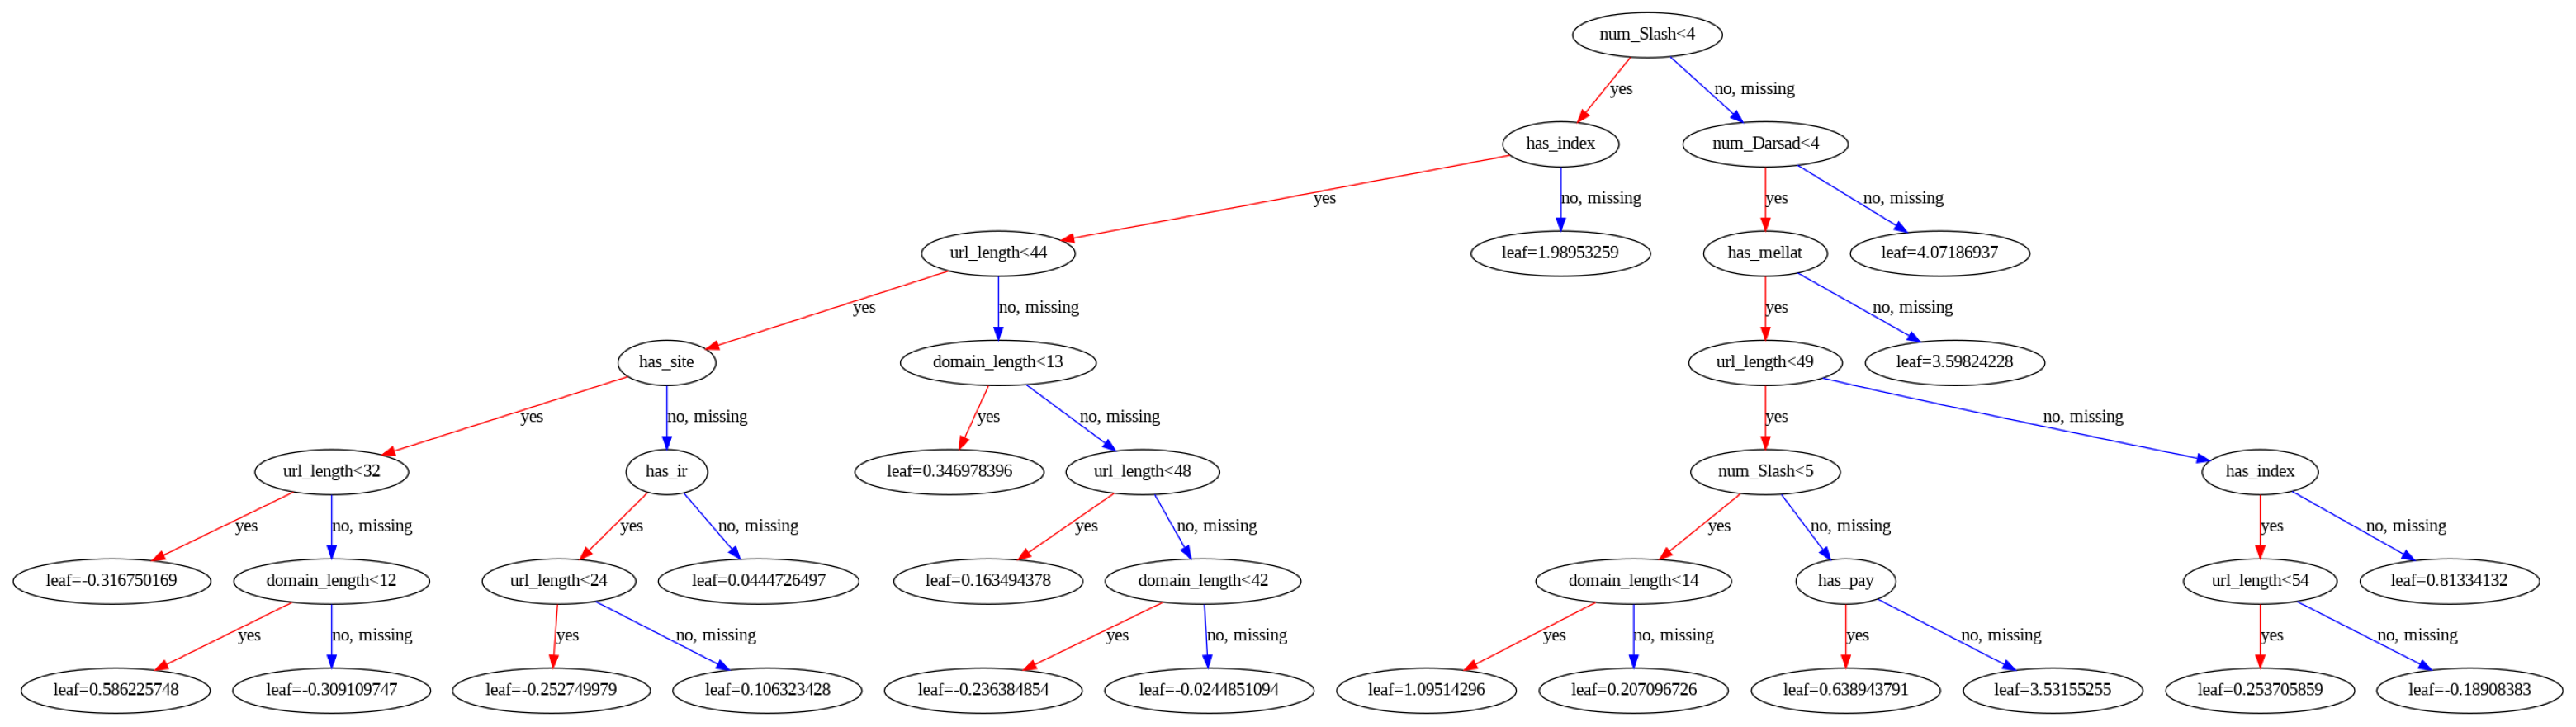

In [ ]:
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import graphviz

# Export the first tree as a .dot file
xgb.to_graphviz(modelXG, num_trees=0)

# Render the dot file using Graphviz
graph = xgb.to_graphviz(modelXG, num_trees=0)
graph.render("xgboost_tree", format="png", cleanup=True)  # Save as PNG

# Display the image in Jupyter or IPython environment
from PIL import Image
img = Image.open("xgboost_tree.png")
plt.figure(figsize=(40, 40))
plt.imshow(img)
plt.axis("off")
plt.show()

5. In this section, we train and evaluate multiple machine learning models on URL data using TF-IDF features. First, the URLs are converted into numerical representations with TfidfVectorizer, capturing character-level patterns in the links. Four models—XGBoost, AdaBoost, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM)—are then trained on the vectorized URL features. For each model, predictions on the test set are evaluated and visualized using a confusion matrix, which shows the number of correctly and incorrectly classified phishing and non-phishing URLs. This process provides a clear understanding of each model’s performance and highlights which models are more effective at detecting phishing URLs based purely on URL text patterns.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:32:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


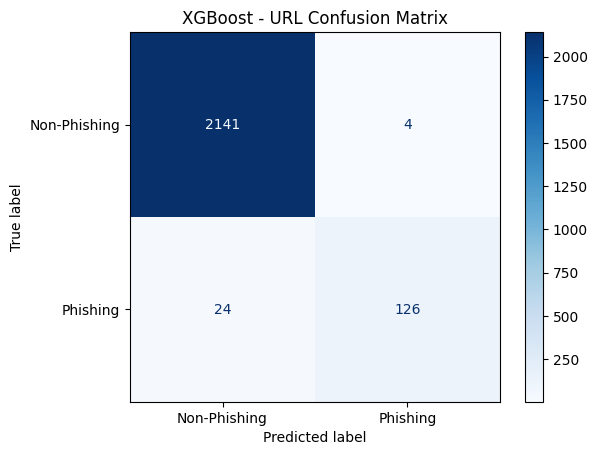

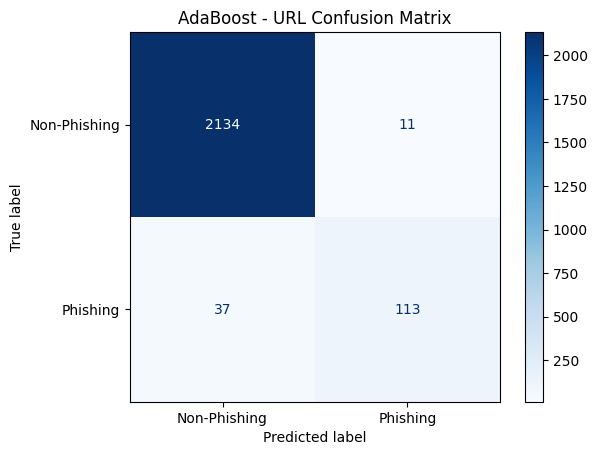

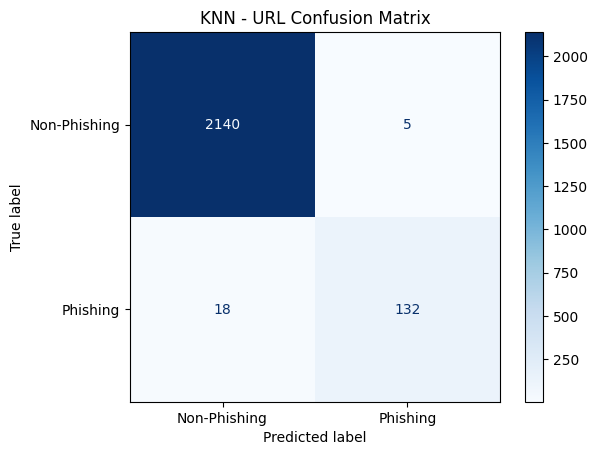

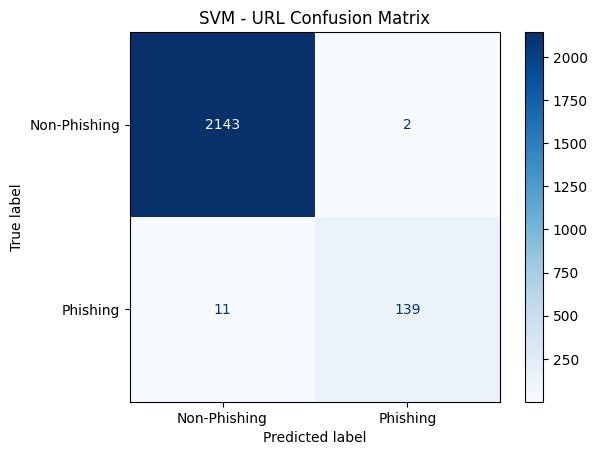

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter

# Load data from Excel files
website_data = pd.read_excel('website-train.xlsx')

# Separate attributes and tags for URL model (website)
X_website = website_data[['url']]
y_website = website_data['is_phishing']


# Splitting the data into training and testing data
X_train_website, X_test_website, y_train_website, y_test_website = train_test_split(X_website, y_website, test_size=0.2, random_state=42)


# Models
models = {
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', C=1, random_state=42)
}

# Using TfidfVectorizer to convert URLs to numeric features
vectorizer = TfidfVectorizer()

# Train and evaluate models for URL data
for model_name, model in models.items():
    # Convert URLs to numeric attributes
    X_train_website_vec = vectorizer.fit_transform(X_train_website['url'])
    X_test_website_vec = vectorizer.transform(X_test_website['url'])

    # Convert sparse data to dense for models that only accept dense data
    if hasattr(model, 'fit'):
        if isinstance(X_train_website_vec, type(X_test_website_vec)):
            X_train_website_vec = X_train_website_vec.toarray()
            X_test_website_vec = X_test_website_vec.toarray()

    # Model training
    model.fit(X_train_website_vec, y_train_website)
    y_pred_website = model.predict(X_test_website_vec)

    # Display confusion matrix for URL data
    cm_website = confusion_matrix(y_test_website, y_pred_website)
    disp_website = ConfusionMatrixDisplay(confusion_matrix=cm_website, display_labels=['Non-Phishing', 'Phishing'])
    disp_website.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} - URL Confusion Matrix')
    plt.show()


**Conclusion**

In summary, this project demonstrates that machine learning models can effectively detect phishing URLs using structural features and character-level patterns. Across multiple algorithms, the system achieved high accuracy, and confusion matrices provided insights into model performance. Visualizing decision trees from XGBoost further enhanced interpretability, while the predict_url function allows easy testing of new URLs. Overall, this approach provides a scalable, efficient, and understandable framework for phishing detection, suitable for both research and practical applications.